# Emcee with PyMC3

[Emcee](http://dan.iel.fm/emcee/current/) provides the Affine Invariant Ensemble Sampler (documented [here](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml)). AIEMCMC is known to be very efficient at sampling distributions with degenerate parameters (i.e. the banana distribution).

This external plugin allows for the combination of PyMC3's model specification in Theano with the super efficient Emcee sampler! 

Now we can specify complex models really easily and also sample them very quickly! 

start with some standard imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

%matplotlib inline

generate some data for a straight line example

In [2]:
true_gradient = 3
true_intercept = 4
noise = 0.1
np.random.seed(0)

x = np.linspace(0, 1, 50)
y = true_intercept + (x * true_gradient)
y = np.random.normal(y, noise)

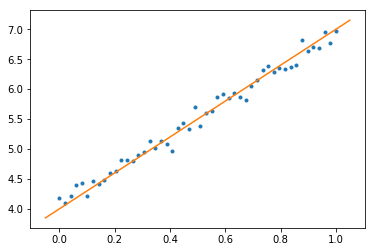

In [3]:
plt.plot(x, y, '.')
X = np.linspace(*plt.xlim())
Y = true_intercept + (true_gradient * X)
plt.plot(X, Y, '-');

specify the model in pymc3 with 2 very wide normal priors on the gradient and intercept

In [4]:
with pm.Model() as model:
    g = pm.Normal('gradient', 0, 5)  # priors
    i = pm.Normal('intercept', 0, 5)
    eps = pm.HalfCauchy('eps', 10)
    pm.Normal('like', i + (x*g), eps, observed=y)

You can sample with initial positions drawn randomly from the priors: `init=random`,

or you can sample using advi: `init=advi`.

In [5]:
from pymc3.external.emcee import AffineInvariantEnsemble

with model:
    trace = pm.sample(1000, step=AffineInvariantEnsemble(), init='random')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1573.81it/s]


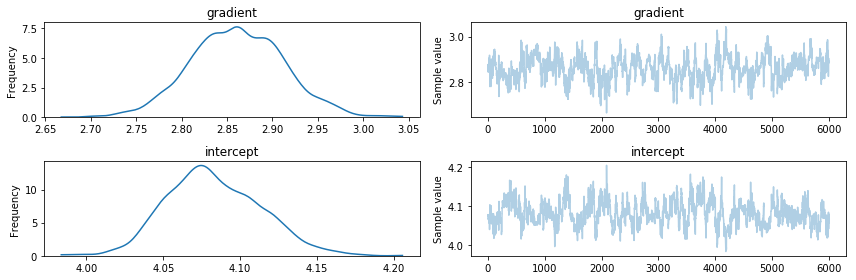

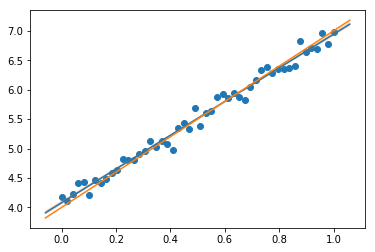

In [6]:
pm.traceplot(trace, ['gradient', 'intercept'], combined=True) # combined=True allows you to view all the walkers at once  

plt.figure()
plt.scatter(x, y)
X = np.linspace(*plt.xlim())
Ys = (trace.get_values('gradient')[None, ...] * X[..., None]) + trace.get_values('intercept')[None, ...]
Yp = np.percentile(Ys, [16, 50, 84], axis=1)
plt.plot(X, Yp[1])
plt.fill_between(X, Yp[0], Yp[2], alpha=0.4)
plt.plot(X, true_gradient*X + true_intercept);